In [1]:
from week12_functions import *
def plot_graph(ax, graph, s=1000, global_label=False):
    xmin = float(torch.min(graph.pos[:,0]))
    xmax = float(torch.max(graph.pos[:,0]))
    ymin = float(torch.min(graph.pos[:,1]))
    ymax = float(torch.max(graph.pos[:,1]))
    ax.set(xlim=(xmin-1, xmax+1), ylim=(ymin-1, ymax+1))

    # Display the global label if requested:
    if global_label:
        ax.text(1.0, 0.5, float(graph.y), color='black', ha='right', va='center', transform=ax.transAxes, bbox=dict(facecolor='yellow', boxstyle='square,pad=0.2'))
    
    # Plot the nodes:
    if global_label:
        for idx, (pos, x) in enumerate(zip(graph.pos, graph.x)):
            text_offset = pos + s**0.5 * torch.tensor([0.01, 0.01])
            ax.scatter(*pos.T, c=f'C{int(x)}', s=s, edgecolors='black')
            ax.text(*pos.T, round(float(x), 1), color='white', ha='center', va='center')
            ax.text(*text_offset.T, f'{idx}', color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.2'))
        ax.text(1.0, 0.5, float(graph.y), color='black', ha='right', va='center', transform=ax.transAxes, bbox=dict(facecolor='yellow', boxstyle='square,pad=0.2'))
    else:
        for idx, (pos, x, y) in enumerate(zip(graph.pos, graph.x, graph.y)):
            text_offset = pos + s**0.5 * torch.tensor([0.01, 0.01])
            ax.scatter(*pos.T, c=f'C{int(y)}', s=s, edgecolors='black')
            ax.text(*pos.T, round(float(y), 1), color='white', ha='center', va='center')
            ax.text(*text_offset.T, f'{idx}', color='black', ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black', boxstyle='square,pad=0.2'))

    # Plot the edges:
    for idx, (i1,i2) in enumerate(graph.edge_index.T):
        ax.plot([graph.pos[i1,0], graph.pos[i2,0]], [graph.pos[i1,1], graph.pos[i2,1]], c='black', zorder=0)

### 7.1 Trainable GNNs
This exercise is about setting up various GNNs and train their free parameters to predict some properties on the graphs. The properties will be either the node-wise number of nearest neighbors, or the graph-wise number of edges.

The exercise uses these graphs:

In [2]:
g0 = Data(edge_index=torch.tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4],
    [0, 1, 3, 0, 1, 2, 1, 2, 4, 0, 3, 2, 4]]), pos=torch.tensor([[4.963, 7.682],
    [3.074, 6.341],[3.489, 4.017],[6.977, 8.   ],[1.61 , 2.823]],dtype=torch.float32),
    y=torch.tensor([2, 2, 2, 1, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g1 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 1, 1, 2, 2, 2, 3, 3, 4, 4],
    [0, 1, 2, 3, 0, 1, 0, 2, 4, 0, 3, 2, 4]]), pos=torch.tensor([[4.963, 4.012],
    [6.806, 5.142],[4.431, 6.432],[5.159, 1.636],[1.955, 6.691]], dtype=torch.float32),
    y=torch.tensor([3, 1, 2, 1, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g2 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 4, 4],
    [0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 3, 4, 0, 2, 3, 2, 4]]), pos=torch.tensor([[7.698, 7.945],
    [5.712, 7.06 ],[7.608, 5.876],[9.736, 6.541],[6.81 , 3.582]], dtype=torch.float32),
    y=torch.tensor([3, 2, 4, 2, 1.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g3 = Data(edge_index=torch.tensor([
    [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    [0, 1, 2, 0, 1, 4, 0, 2, 3, 2, 3, 4, 1, 3, 4]]), pos=torch.tensor([[4.488, 7.382],
    [5.241, 9.701],[5.269, 5.412],[7.128, 6.766],[7.317, 8.692]], dtype=torch.float32),
    y=torch.tensor([2, 2, 2, 2, 2.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g4 = Data(edge_index=torch.tensor([
    [0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4],
    [0, 1, 2, 3, 4, 0, 1, 4, 0, 2, 3, 0, 2, 3, 0, 1, 4]]), pos=torch.tensor([[2.753, 8.131],
    [0.719, 7.519],[5.007, 7.139],[4.68 , 9.057],[1.645, 9.674]], dtype=torch.float32),
    y=torch.tensor([4, 2, 2, 2, 2.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))
g5 = Data(edge_index=torch.tensor([
    [0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 4, 4, 4],
    [0, 1, 0, 1, 2, 4, 1, 2, 3, 4, 2, 3, 1, 2, 4]]), pos=torch.tensor([[4.554, 1.77 ],
    [3.023, 3.16 ],[1.27 , 4.22 ],[0.436, 6.327],[0.976, 1.79 ]], dtype=torch.float32),
    y=torch.tensor([0, 0, 0, 0, 0.],dtype=torch.float32).view(-1,1), x=torch.ones(5,1))

a) Plot the six graphs while coloring (or annotating) the $i$'th node in each graph with the $i$'th entry in the graph's `y`-attribute.

C:\Users\Jakob\AppData\Local\Temp\ipykernel_25864\689426552.py:24: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3687.)
  ax.scatter(*pos.T, c=f'C{int(y)}', s=s, edgecolors='black')


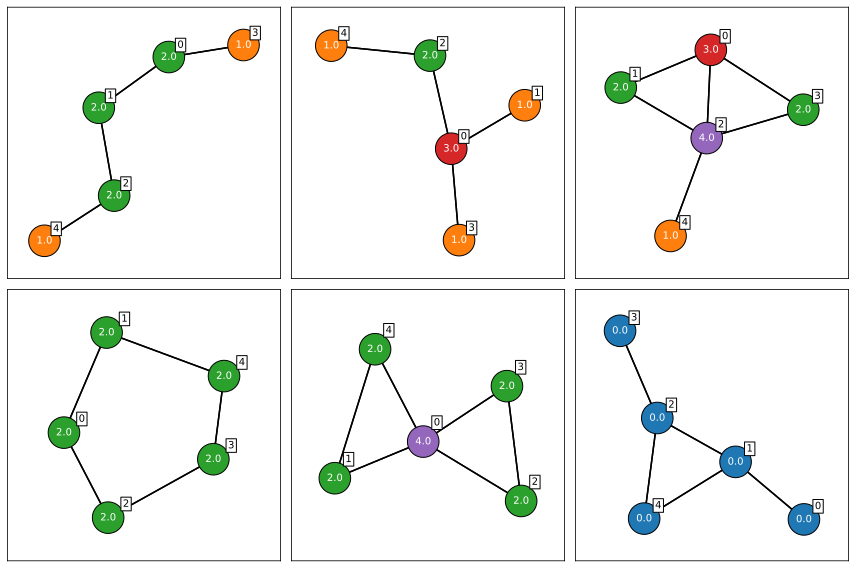

In [3]:
list_of_graphs = [g0, g1, g2, g3, g4, g5]
fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, graph in zip(axes.flatten(), list_of_graphs):
    plot_graph(ax, graph)
    nice_plot_nodes(ax)
plt.tight_layout()

fig.savefig('ex61_fig1.png')

As you see, only the first five graphs have good labels. The six'th graph will be used for testing purposes, and we shall judge ourselves if the labels predicted by models appear good. This will be an easy task, since the labels are indeed the number of neighbors that the nodes have.

### 7.2 Parameter-free model
b) Introduce a GNN layer according to:

In [4]:
class NoParamsGNN(MessagePassing):
    def __init__(self,aggr='add'):
        super().__init__(aggr=aggr)

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_j): 
        return x_j

and wrap it in a model, that takes a graph as its input:

In [5]:
no_params_gnn = NoParamsGNN()
model = lambda graph: no_params_gnn(graph.x, graph.edge_index)

c) Show that using this model, you get the following model-predictions for the test-graph:

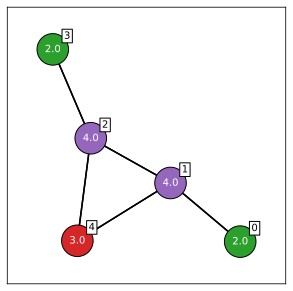

In [6]:
g5_noparams0 = g5.clone()
g5_noparams0.y = model(g5_noparams0)
fig, ax = plt.subplots(figsize=(5,5))
plot_graph(ax, g5_noparams0)
nice_plot_nodes(ax)

fig.savefig('ex61_fig2.png')

### GNN with $\psi$
d) Now introduce a linear transformation, $\psi$, on the message being sent. I.e. implement:
$$ x_i^{k+1} = \sum_{j\in\mathcal{N}_i}\psi(x_j^k) $$
where $\psi$ is given by one neuron.

In [7]:
class PsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = nn.Linear(d_in, d_out)

    def forward(self, x, edge_index):
        x = self.propagate(edge_index, x=x)
        x = x.flatten()
        return x

    def message(self, x_j): 
        return self.psi(x_j)

e) Inspect the model predictions before and after training

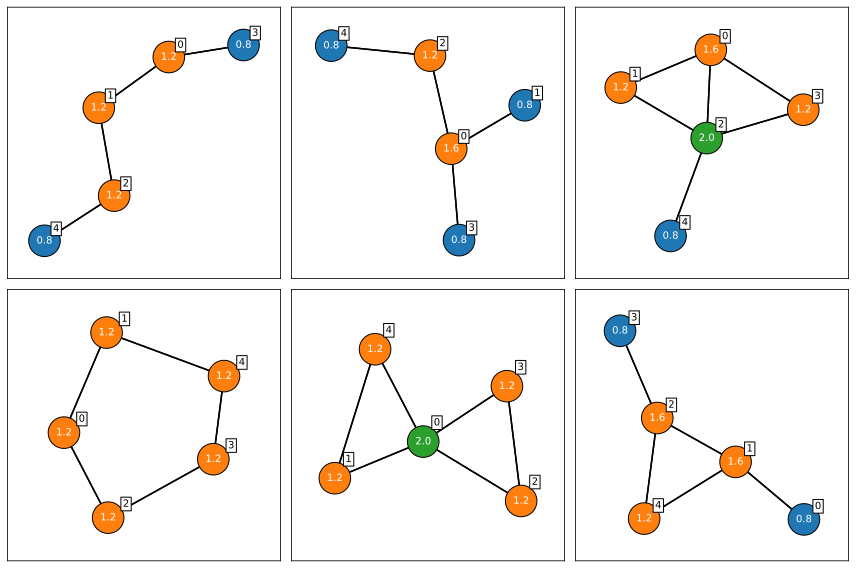

In [8]:
# Predictions for the graphs before training
psi_gnn = PsiGNN(1, 1)

fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, graph in zip(axes.flatten(), list_of_graphs):
    new_graph = graph.clone()
    predictions = psi_gnn(new_graph.x, new_graph.edge_index)
    new_graph.y = predictions
    plot_graph(ax, new_graph, s=1000)
    nice_plot_nodes(ax)

plt.tight_layout()

fig.savefig('ex61_fig3.png')

In [9]:
def train_psi_gnn(model, graphs, optimizer, epochs=2500):
    loss_fn = torch.nn.MSELoss()  # Mean squared error for regression
    losses = []
    for epoch in tqdm(range(epochs), desc=f'Training {model.__class__.__name__}'):
        total_loss = 0
        for graph in graphs:
            optimizer.zero_grad()
            predictions = model(graph.x, graph.edge_index)  # Forward pass
            loss = loss_fn(predictions, graph.y.flatten())  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Update parameters
            total_loss += loss.item()
        
        avg_loss = total_loss / len(graphs)
        losses.append(avg_loss)

    return losses, model

Training PsiGNN: 100%|██████████| 2500/2500 [00:05<00:00, 443.48it/s]


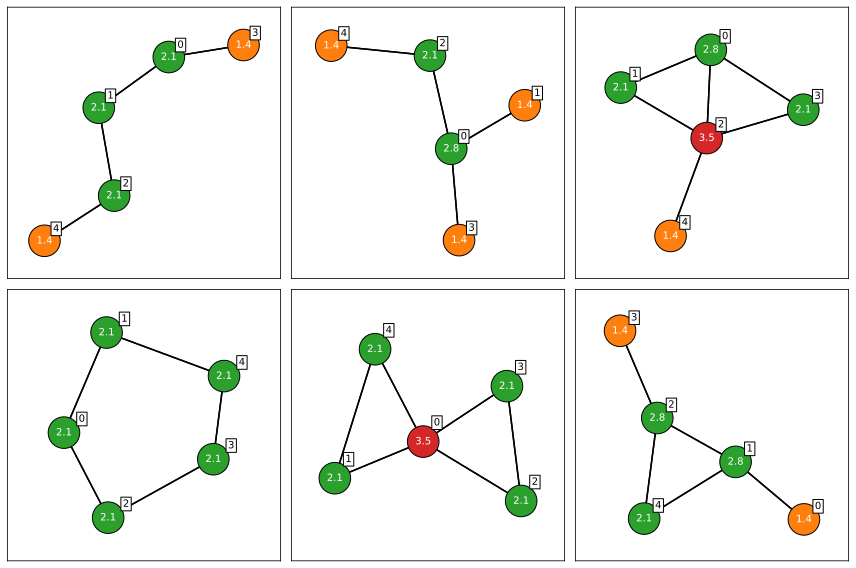

In [10]:
# Define the training graphs
train_graphs = [g0, g1, g2, g3, g4]  # Provided graphs
test_graph = g5  # Provided test graph

# Instantiate the model and optimizer
psi_gnn = PsiGNN(d_in=1, d_out=1)
optimizer = torch.optim.Adam(psi_gnn.parameters(), lr=0.01)

# Train the model
train_psi_gnn(psi_gnn, train_graphs, optimizer, epochs=2500)

# Plot predictions after training
fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, graph in zip(axes.flatten(), list_of_graphs):
    new_graph = graph.clone()
    predictions = psi_gnn(new_graph.x, new_graph.edge_index)
    new_graph.y = predictions
    plot_graph(ax, new_graph, s=1000)
    nice_plot_nodes(ax)

plt.tight_layout()

fig.savefig('ex61_fig4.png')

### 7.4 Dataloader
f) Repeat e), but this time keep the five training graphs in a `Dataloader`.

In [11]:
def train_psi_gnn_with_dataloader(model, loader, optimizer, epochs=2500):
    """
    Train a PsiGNN model using a DataLoader.
    
    Args:
        model: PsiGNN instance.
        loader: DataLoader instance with graphs.
        optimizer: Optimizer for the model.
        epochs: Number of epochs to train.
        
    Returns:
        losses: List of average losses per epoch.
        model: Trained PsiGNN model.
    """
    loss_fn = torch.nn.MSELoss()  # Mean squared error for regression
    losses = []

    for epoch in tqdm(range(epochs), desc=f"Training {model.__class__.__name__}"):
        total_loss = 0
        total_N = 0  # Total number of nodes processed
        
        for batch in loader:
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(batch.x, batch.edge_index)
            
            # Compute loss
            loss = loss_fn(predictions, batch.y.flatten())
            
            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()
            
            # Accumulate loss and node count
            N = batch.num_nodes  # Number of nodes in the current batch
            total_N += N
            total_loss += loss.item() * N
        
        # Average loss over all nodes
        avg_loss = total_loss / total_N
        losses.append(avg_loss)
        
    return losses, model

Training PsiGNN: 100%|██████████| 2500/2500 [00:08<00:00, 288.62it/s]


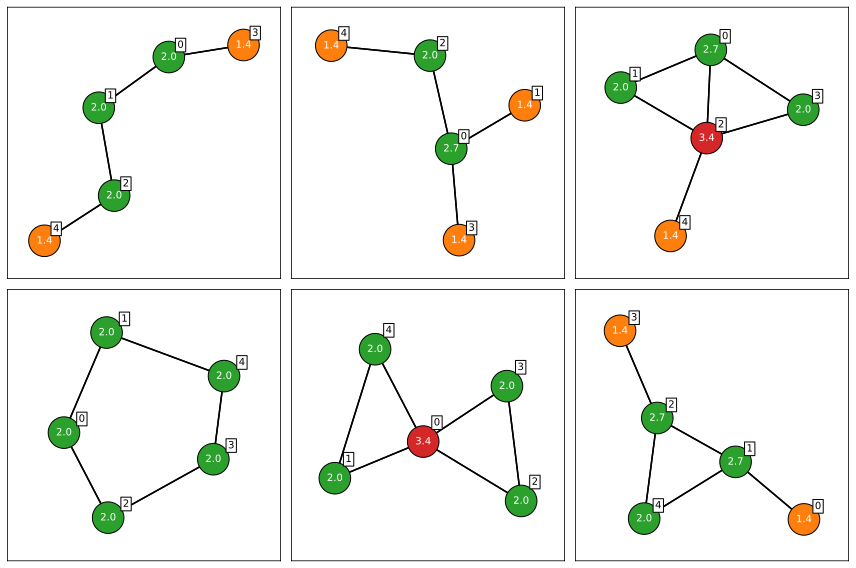

In [12]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)

psi_gnn = PsiGNN(1, 1)  # Example PsiGNN model
optimizer = torch.optim.Adam(psi_gnn.parameters(), lr=0.01)

losses, trained_model = train_psi_gnn_with_dataloader(psi_gnn, train_loader, optimizer, epochs=2500)

# Plot predictions after training
fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, graph in zip(axes.flatten(), list_of_graphs):
    new_graph = graph.clone()
    predictions = psi_gnn(new_graph.x, new_graph.edge_index)
    new_graph.y = predictions
    plot_graph(ax, new_graph, s=1000)
    nice_plot_nodes(ax)

plt.tight_layout()

fig.savefig('ex61_fig5.png')

### 7.5 GNN with $\phi$
To make the model perfect, a $\phi$-function as in
$$ x_i^{k+1} = \phi\left(x_i^k, \sum_{j\in\mathcal{N}_i} c_{ij} \psi(x_j^k)\right) $$
must be introduced.

g) Introduce such a function, described by a trainable neuron.

In [13]:
class PhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        self.psi = nn.Linear(d_in, d_out)
        self.phi = nn.Linear(d_in + d_out, d_out)

    def forward(self, x, edge_index):
        psi_of_x_j = self.propagate(edge_index, x=x)
        x = torch.cat([x, psi_of_x_j], dim=-1)
        x = self.phi(x)
        x = x.flatten()
        return x

    def message(self, x_j):
        return self.psi(x_j)

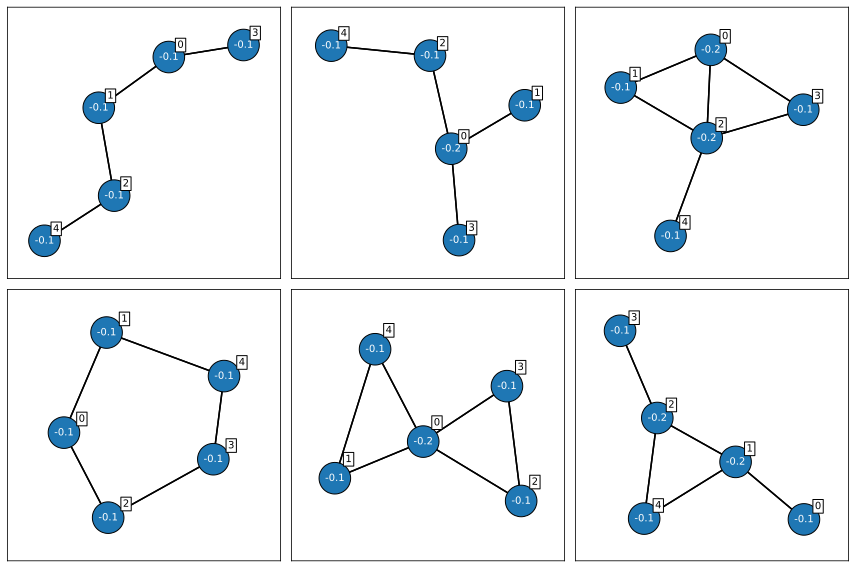

In [14]:
# Predictions for the first five graphs before training
phi_psi_gnn = PhiPsiGNN(1, 1)

fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, graph in zip(axes.flatten(), list_of_graphs):
    new_graph = graph.clone()
    predictions = phi_psi_gnn(new_graph.x, new_graph.edge_index)
    new_graph.y = predictions
    plot_graph(ax, new_graph, s=1000)
    nice_plot_nodes(ax)

plt.tight_layout()

fig.savefig('ex61_fig6.png')

In [15]:
def train_phi_psi_gnn_with_dataloader(model, loader, optimizer, epochs=2500):
    """
    Train a PhiPsiGNN model using a DataLoader.
    
    Args:
        model: PhiPsiGNN instance.
        loader: DataLoader instance with graphs.
        optimizer: Optimizer for the model.
        epochs: Number of epochs to train.
        
    Returns:
        losses: List of average losses per epoch.
        model: Trained PhiPsiGNN model.
    """
    loss_fn = torch.nn.MSELoss()  # Mean squared error for regression
    losses = []

    for epoch in tqdm(range(epochs), desc=f"Training {model.__class__.__name__}"):
        total_loss = 0
        total_N = 0  # Total number of nodes processed
        
        for batch in loader:
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(batch.x, batch.edge_index)

            # Compute loss
            loss = loss_fn(predictions, batch.y.flatten())

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Accumulate loss and node count
            N = batch.num_nodes
            total_N += N
            total_loss += loss.item() * N

        # Average loss over all nodes
        avg_loss = total_loss / total_N
        losses.append(avg_loss)

    return losses, model

Training PhiPsiGNN: 100%|██████████| 2500/2500 [00:09<00:00, 258.22it/s]


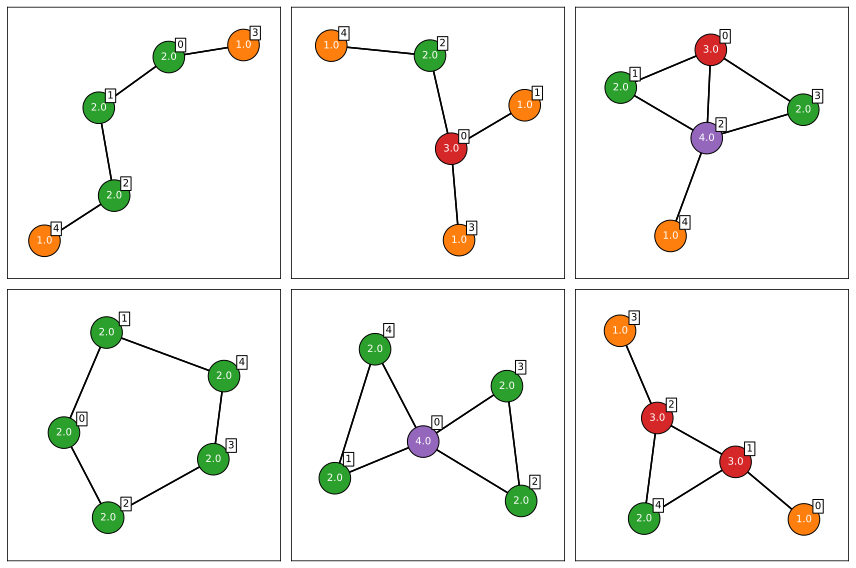

In [16]:
phi_psi_gnn = PhiPsiGNN(1, 1)  # Example PsiGNN model
optimizer = torch.optim.Adam(phi_psi_gnn.parameters(), lr=0.01)

losses, trained_model = train_phi_psi_gnn_with_dataloader(phi_psi_gnn, train_loader, optimizer, epochs=2500)

# Plot predictions after training
fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, graph in zip(axes.flatten(), list_of_graphs):
    new_graph = graph.clone()
    predictions = phi_psi_gnn(new_graph.x, new_graph.edge_index)
    new_graph.y = predictions
    plot_graph(ax, new_graph, s=1000)
    nice_plot_nodes(ax)

plt.tight_layout()

fig.savefig('ex61_fig7.png')

### 7.6 Number of bonds as target
i) Make a new set of graphs, where the graph-attribute is no longer a vector with the coordination numbers, but rather the total number of bonds on the graph:

In [17]:
all_graphs_global_labels_only = []
for graph in list_of_graphs:
    g = Data(edge_index=graph.edge_index, x=graph.x, pos=graph.pos, y=torch.sum(graph.y/2))
    all_graphs_global_labels_only.append(g)

all_graphs_global_labels_only

[Data(x=[5, 1], edge_index=[2, 13], y=4.0, pos=[5, 2]),
 Data(x=[5, 1], edge_index=[2, 13], y=4.0, pos=[5, 2]),
 Data(x=[5, 1], edge_index=[2, 17], y=6.0, pos=[5, 2]),
 Data(x=[5, 1], edge_index=[2, 15], y=5.0, pos=[5, 2]),
 Data(x=[5, 1], edge_index=[2, 17], y=6.0, pos=[5, 2]),
 Data(x=[5, 1], edge_index=[2, 15], y=0.0, pos=[5, 2])]

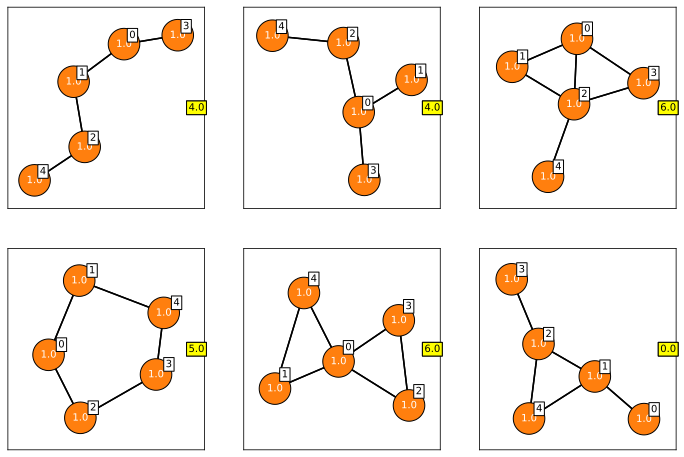

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(12,8))
for ax, graph in zip(axes.flatten(), all_graphs_global_labels_only):
    plot_graph(ax, graph, s=1000, global_label=True)
    nice_plot_nodes(ax)

fig.savefig('ex61_fig8.png')

In [19]:
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation
import torch.nn as nn

class AggrPhiPsiGNN(MessagePassing):
    def __init__(self, d_in, d_out, aggr='add'):
        super().__init__(aggr=aggr)
        
        # Define psi as a trainable linear layer
        self.psi = nn.Linear(d_in, d_out)

        # Define phi as a trainable neuron combining original x_i and aggregated psi(x_j)
        self.phi = nn.Linear(d_in + d_out, d_out)

        # Aggregation layer to compute global graph attribute
        self.aggr = SumAggregation()

    def forward(self, x, edge_index, batch):
        # Step 1: Aggregate psi(x_j) from neighbors
        psi_of_x_j = self.propagate(edge_index, x=x)

        # Step 2: Concatenate x_i with aggregated psi(x_j) and pass through phi
        x = torch.cat([x, psi_of_x_j], dim=-1)  # Concatenate
        x = self.phi(x)  # Pass through phi

        # Step 3: Aggregate node features to a global value for the graph
        y = self.aggr(x, batch)

        return x, y  # Return both local (x) and global (y) predictions

    def message(self, x_j):
        # Apply psi to each neighboring node feature
        return self.psi(x_j)

In order to perform the aggregation correctly for batched graphs, the message passing layer requires `batch` as an input. This means that the wrapping model must be changed slightly:

In [20]:
model = lambda graph: aggr_phi_psi_gnn(graph.x, graph.edge_index, graph.batch)

In [21]:
def train_aggr_phi_psi_gnn(model, loader, optimizer, epochs=2500):
    """
    Train AggrPhiPsiGNN with batched graphs.

    Args:
        model: AggrPhiPsiGNN instance.
        loader: DataLoader instance with batched graphs.
        optimizer: Optimizer for the model.
        epochs: Number of epochs to train.

    Returns:
        losses: List of average losses per epoch.
        model: Trained AggrPhiPsiGNN model.
    """
    loss_fn = nn.MSELoss()  # Mean squared error for regression
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        model.train()  # Set model to training mode

        for batch in loader:
            optimizer.zero_grad()

            # Forward pass
            _, global_predictions = model(batch.x, batch.edge_index, batch.batch)

            # Ensure the global predictions and batch.y are compatible
            global_predictions = global_predictions.flatten()  # Flatten to match batch.y

            # Compute loss
            loss = loss_fn(global_predictions, batch.y.flatten())

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * batch.num_graphs

        # Average loss per graph
        avg_loss = total_loss / len(loader.dataset)
        losses.append(avg_loss)

    return losses, model

In [22]:
# Create the model instance
aggr_phi_psi_gnn = AggrPhiPsiGNN(d_in=1, d_out=1)

# Define the optimizer
optimizer = torch.optim.Adam(aggr_phi_psi_gnn.parameters(), lr=0.01)

# Prepare the DataLoader
train_loader = DataLoader(train_graphs, batch_size=2, shuffle=True)

# Train the model
losses, trained_model = train_aggr_phi_psi_gnn(aggr_phi_psi_gnn, train_loader, optimizer, epochs=2500)

# Plot the training loss curve
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(range(len(losses)), losses, label="Training Loss")
ax.set(xlabel="Epochs", ylabel="Loss", title="Training Loss Curve")
ax.legend()
ax.grid(alpha=0.5)
plt.tight_layout()
plt.show()

# Plot predictions for the first few graphs after training
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, graph in zip(axes.flatten(), train_graphs[:3]):
    graph = graph.clone()
    _, global_prediction = trained_model(graph.x, graph.edge_index, torch.zeros(graph.x.size(0), dtype=torch.long))
    graph.y = global_prediction.detach()  # Replace graph label with prediction
    plot_graph(ax, graph, s=1000, global_label=True)

plt.tight_layout()

c:\Users\Jakob\anaconda3\envs\COMPHY\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (2) must match the size of tensor b (10) at non-singleton dimension 0